__Exploratory Data Analysis (EDA)__

- Inspect distributions, missing values, outliers.
- Plot time series of IV, skew, curvature.
- Compare SPY vs QQQ.
- Correlation checks.
- Document findings.

In [1]:
# import parquet_extractor  
# import importlib

# importlib.reload(parquet_extractor) 

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from parquet_extractor import load_ticker_year_data, get_ticker_metadata

__Load the filtered parquet__

In [3]:
# metadata = get_ticker_metadata('SPY', Path("."))
# metadata

In [4]:
def load_merged_ticker_data(tickers, start_year, end_year, data_dir=Path(".")):
    """Load and merge data for multiple tickers across a range of years."""
    all_data = []

    if isinstance(tickers, str):
        tickers = [tickers]

    for ticker in tickers:
        for year in range(start_year, end_year + 1):
            try:
                df = load_ticker_year_data(ticker, year, data_dir)
                df = df.with_columns([
                    pl.lit(ticker).alias("ticker"),
                ])
                all_data.append(df)
            except FileNotFoundError:
                print(f"Data not found for {ticker} in {year}, skipping.")
            except Exception as e:
                print(f"Error loading {ticker} in {year}: {e}")

    if all_data:
        return pl.concat(all_data)
    else:
        return pl.DataFrame()

In [5]:
spy_df = load_merged_ticker_data('SPY', 2023, 2023, Path(".")).to_pandas()
spy_df.sample(7)

,date,secid,symbol,cp_flag,exdate,strike_price,best_bid,best_offer,volume,open_interest,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,ticker
1245885,2023-06-07,109820.0,SPY 230915C434000,C,2023-09-15,434000.0,9.65,9.86,132.0,7732.0,...,0.00000,0.00000,-1.48001,-1.48001,-0.55002,4.72998,6.53000,11.31998,21.41999,SPY
1542592,2023-07-19,109820.0,SPY 240621P480000,P,2024-06-21,480000.0,30.13,31.63,49.0,85.0,...,0.00000,0.00000,0.00000,1.01001,4.36001,5.92001,12.74002,11.92001,15.74002,SPY
1491757,2023-08-28,109820.0,SPY 230901C467000,C,2023-09-01,467000.0,0.00,0.01,7.0,6692.0,...,0.00000,2.79001,2.79001,5.87000,-0.26999,3.42001,-5.34998,-7.36999,-11.44000,SPY
13659,2023-03-15,109820.0,SPY 230317P180000,P,2023-03-17,180000.0,0.00,0.01,1.0,3883.0,...,3.92001,3.92001,3.37000,-2.28000,-14.91000,-9.26001,-23.54999,-17.20001,8.45999,SPY
51560,2023-05-08,109820.0,SPY 230915P225000,P,2023-09-15,225000.0,0.48,0.49,1.0,1571.0,...,0.10999,0.10999,7.60999,1.89999,8.38000,-1.20001,4.06998,16.63000,13.64999,SPY
1280594,2023-08-03,109820.0,SPY 230825P437000,P,2023-08-25,437000.0,2.15,2.16,352.0,891.0,...,-1.29000,-1.29000,-1.29000,-7.64001,-8.95001,-8.08001,-6.60000,-6.36001,9.18000,SPY
1547901,2023-06-06,109820.0,SPY 230818C485000,C,2023-08-18,485000.0,0.06,0.07,6.0,584.0,...,0.92999,0.92999,0.10999,6.20999,7.85001,16.94000,17.78000,20.01001,14.09000,SPY


In [6]:
qqq_df = load_merged_ticker_data('QQQ', 2023, 2023, Path(".")).to_pandas()
qqq_df.sample(7)

,date,secid,symbol,cp_flag,exdate,strike_price,best_bid,best_offer,volume,open_interest,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,ticker
243808,2023-05-11,107899.0,QQQ 231215P300000,P,2023-12-15,300000.0,11.68,11.76,54.0,45706.0,...,1.06000,4.56000,2.51001,2.51001,10.03000,4.01001,14.33001,7.36001,6.05002,QQQ
353658,2023-05-17,107899.0,QQQ 230721C318000,C,2023-07-21,318000.0,20.69,20.89,39.0,8905.0,...,0.00000,0.00000,3.96000,4.32999,6.09000,5.97999,14.94999,19.25000,11.94999,QQQ
292586,2023-05-17,107899.0,QQQ 230818P308000,P,2023-08-18,308000.0,5.53,5.58,35.0,10003.0,...,3.96000,3.96000,3.96000,4.32999,6.09000,8.22999,11.74000,12.28000,25.76001,QQQ
155296,2023-04-11,107899.0,QQQ 230421C285000,C,2023-04-21,285000.0,31.20,31.38,59.0,1284.0,...,-2.04001,-2.04001,-2.04001,-2.22000,-3.24002,-5.10000,6.07999,18.00998,12.53000,QQQ
678821,2023-08-11,107899.0,QQQ 230915P400000,P,2023-09-15,400000.0,33.93,34.17,515.0,90.0,...,-2.35001,-1.67001,-1.67001,-5.76001,-5.80002,-16.55002,-12.54001,-12.83002,3.69998,QQQ
576565,2023-08-01,107899.0,QQQ 230818P362000,P,2023-08-18,362000.0,0.79,0.81,637.0,3227.0,...,-0.88998,-0.88998,-0.69000,-0.69000,5.27002,6.56000,-2.85998,14.62000,18.96002,QQQ
227995,2023-04-04,107899.0,QQQ 230421C298000,C,2023-04-21,298000.0,22.37,22.54,1.0,3083.0,...,-1.07998,-1.07998,-1.85998,-1.85998,6.35001,10.31000,12.95001,21.70001,27.87000,QQQ


__Inspect distributions, missing values, outliers__

In [7]:
spy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656604 entries, 0 to 1656603
Data columns (total 37 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   date               1656604 non-null  datetime64[ms]
 1   secid              1656604 non-null  float64       
 2   symbol             1656604 non-null  object        
 3   cp_flag            1656604 non-null  object        
 4   exdate             1656604 non-null  datetime64[ms]
 5   strike_price       1656604 non-null  float64       
 6   best_bid           1656604 non-null  float64       
 7   best_offer         1656604 non-null  float64       
 8   volume             1656604 non-null  float64       
 9   open_interest      1656604 non-null  float64       
 10  impl_volatility    1656604 non-null  float64       
 11  delta              1656604 non-null  float64       
 12  vega               1656604 non-null  float64       
 13  theta              1656604 

In [8]:
spy_df.isna().sum()

date                       0
secid                      0
symbol                     0
cp_flag                    0
exdate                     0
strike_price               0
best_bid                   0
best_offer                 0
volume                     0
open_interest              0
impl_volatility            0
delta                      0
vega                       0
theta                      0
forward_price        1656604
expiry_indicator     1212555
prc                        0
vol                        0
iv_30d                     0
year                       0
vol_delta_product          0
moneyness                  0
volume_ma5                 0
iv_rolling_std             0
price_diff_1d              0
price_diff_2d              0
price_diff_3d              0
price_diff_5d              0
price_diff_8d              0
price_diff_13d             0
price_diff_21d             0
price_diff_34d             0
price_diff_55d             0
price_diff_89d             0
price_diff_144

In [9]:
qqq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714692 entries, 0 to 714691
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               714692 non-null  datetime64[ms]
 1   secid              714692 non-null  float64       
 2   symbol             714692 non-null  object        
 3   cp_flag            714692 non-null  object        
 4   exdate             714692 non-null  datetime64[ms]
 5   strike_price       714692 non-null  float64       
 6   best_bid           714692 non-null  float64       
 7   best_offer         714692 non-null  float64       
 8   volume             714692 non-null  float64       
 9   open_interest      714692 non-null  float64       
 10  impl_volatility    714692 non-null  float64       
 11  delta              714692 non-null  float64       
 12  vega               714692 non-null  float64       
 13  theta              714692 non-null  float64 

In [10]:
qqq_df.isna().sum()

date                      0
secid                     0
symbol                    0
cp_flag                   0
exdate                    0
strike_price              0
best_bid                  0
best_offer                0
volume                    0
open_interest             0
impl_volatility           0
delta                     0
vega                      0
theta                     0
forward_price        714692
expiry_indicator     562543
prc                       0
vol                       0
iv_30d                    0
year                      0
vol_delta_product         0
moneyness                 0
volume_ma5                0
iv_rolling_std            0
price_diff_1d             0
price_diff_2d             0
price_diff_3d             0
price_diff_5d             0
price_diff_8d             0
price_diff_13d            0
price_diff_21d            0
price_diff_34d            0
price_diff_55d            0
price_diff_89d            0
price_diff_144d           0
price_diff_233d     

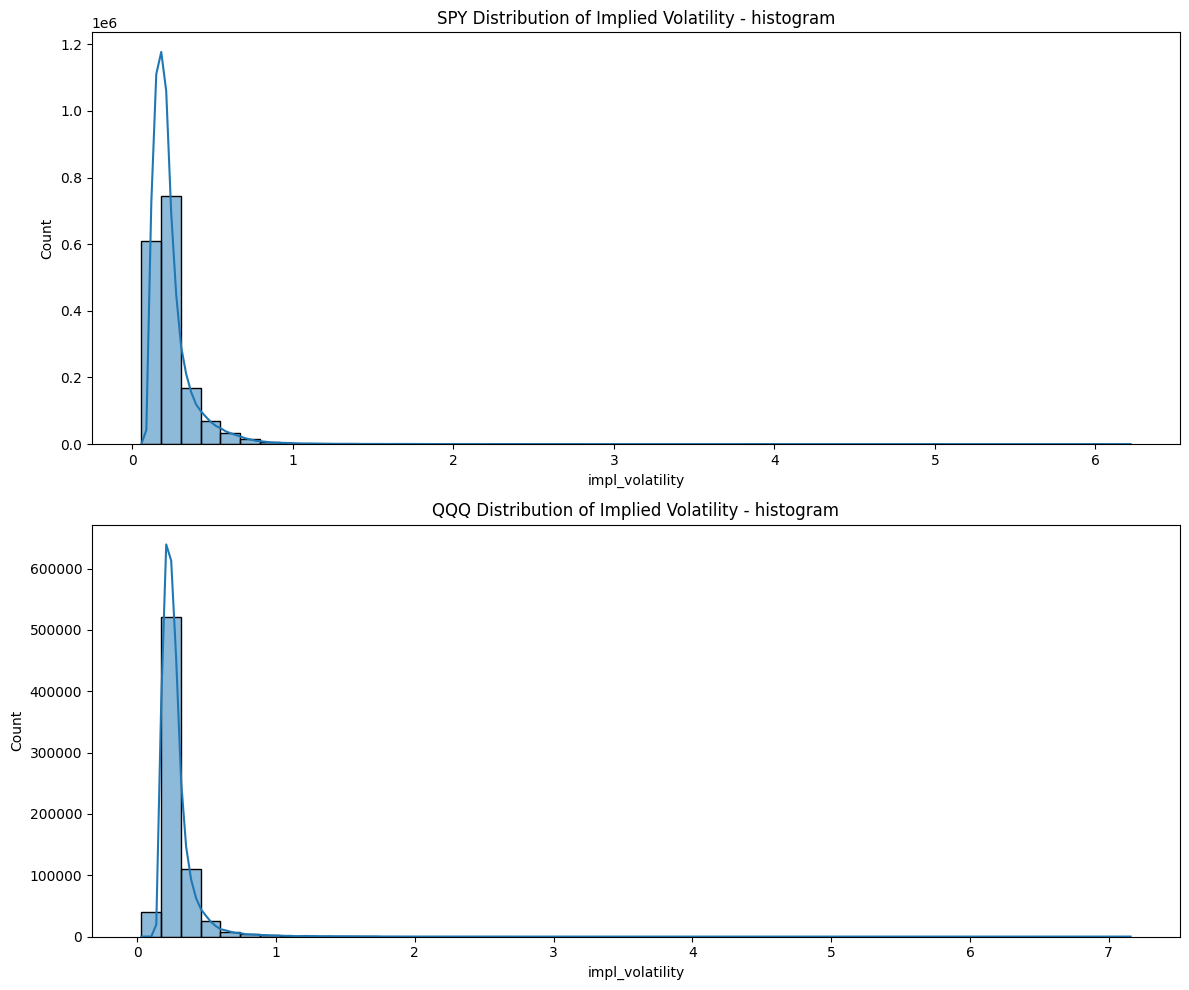

In [11]:
fig, axes = plt.subplots(2,1, figsize=(12,10))

# SPY Distribution of IV
sns.histplot(data=spy_df, x='impl_volatility', bins=50, kde=True, ax = axes[0])
axes[0].set_title("SPY Distribution of Implied Volatility - histogram")

# QQQ Distribution of IV
sns.histplot(data=qqq_df, x='impl_volatility', bins=50, kde=True, ax = axes[1])
axes[1].set_title("QQQ Distribution of Implied Volatility - histogram")


plt.tight_layout()
plt.show()

In [41]:
# Cap IV values at the 99th percentile
spy_iv_cap = spy_df['impl_volatility'].quantile(0.999)
spy_df['impl_volatility'] = np.minimum(spy_df['impl_volatility'], spy_iv_cap)

qqq_iv_cap = qqq_df['impl_volatility'].quantile(0.999)
qqq_df['impl_volatility'] = np.minimum(qqq_df['impl_volatility'], qqq_iv_cap)

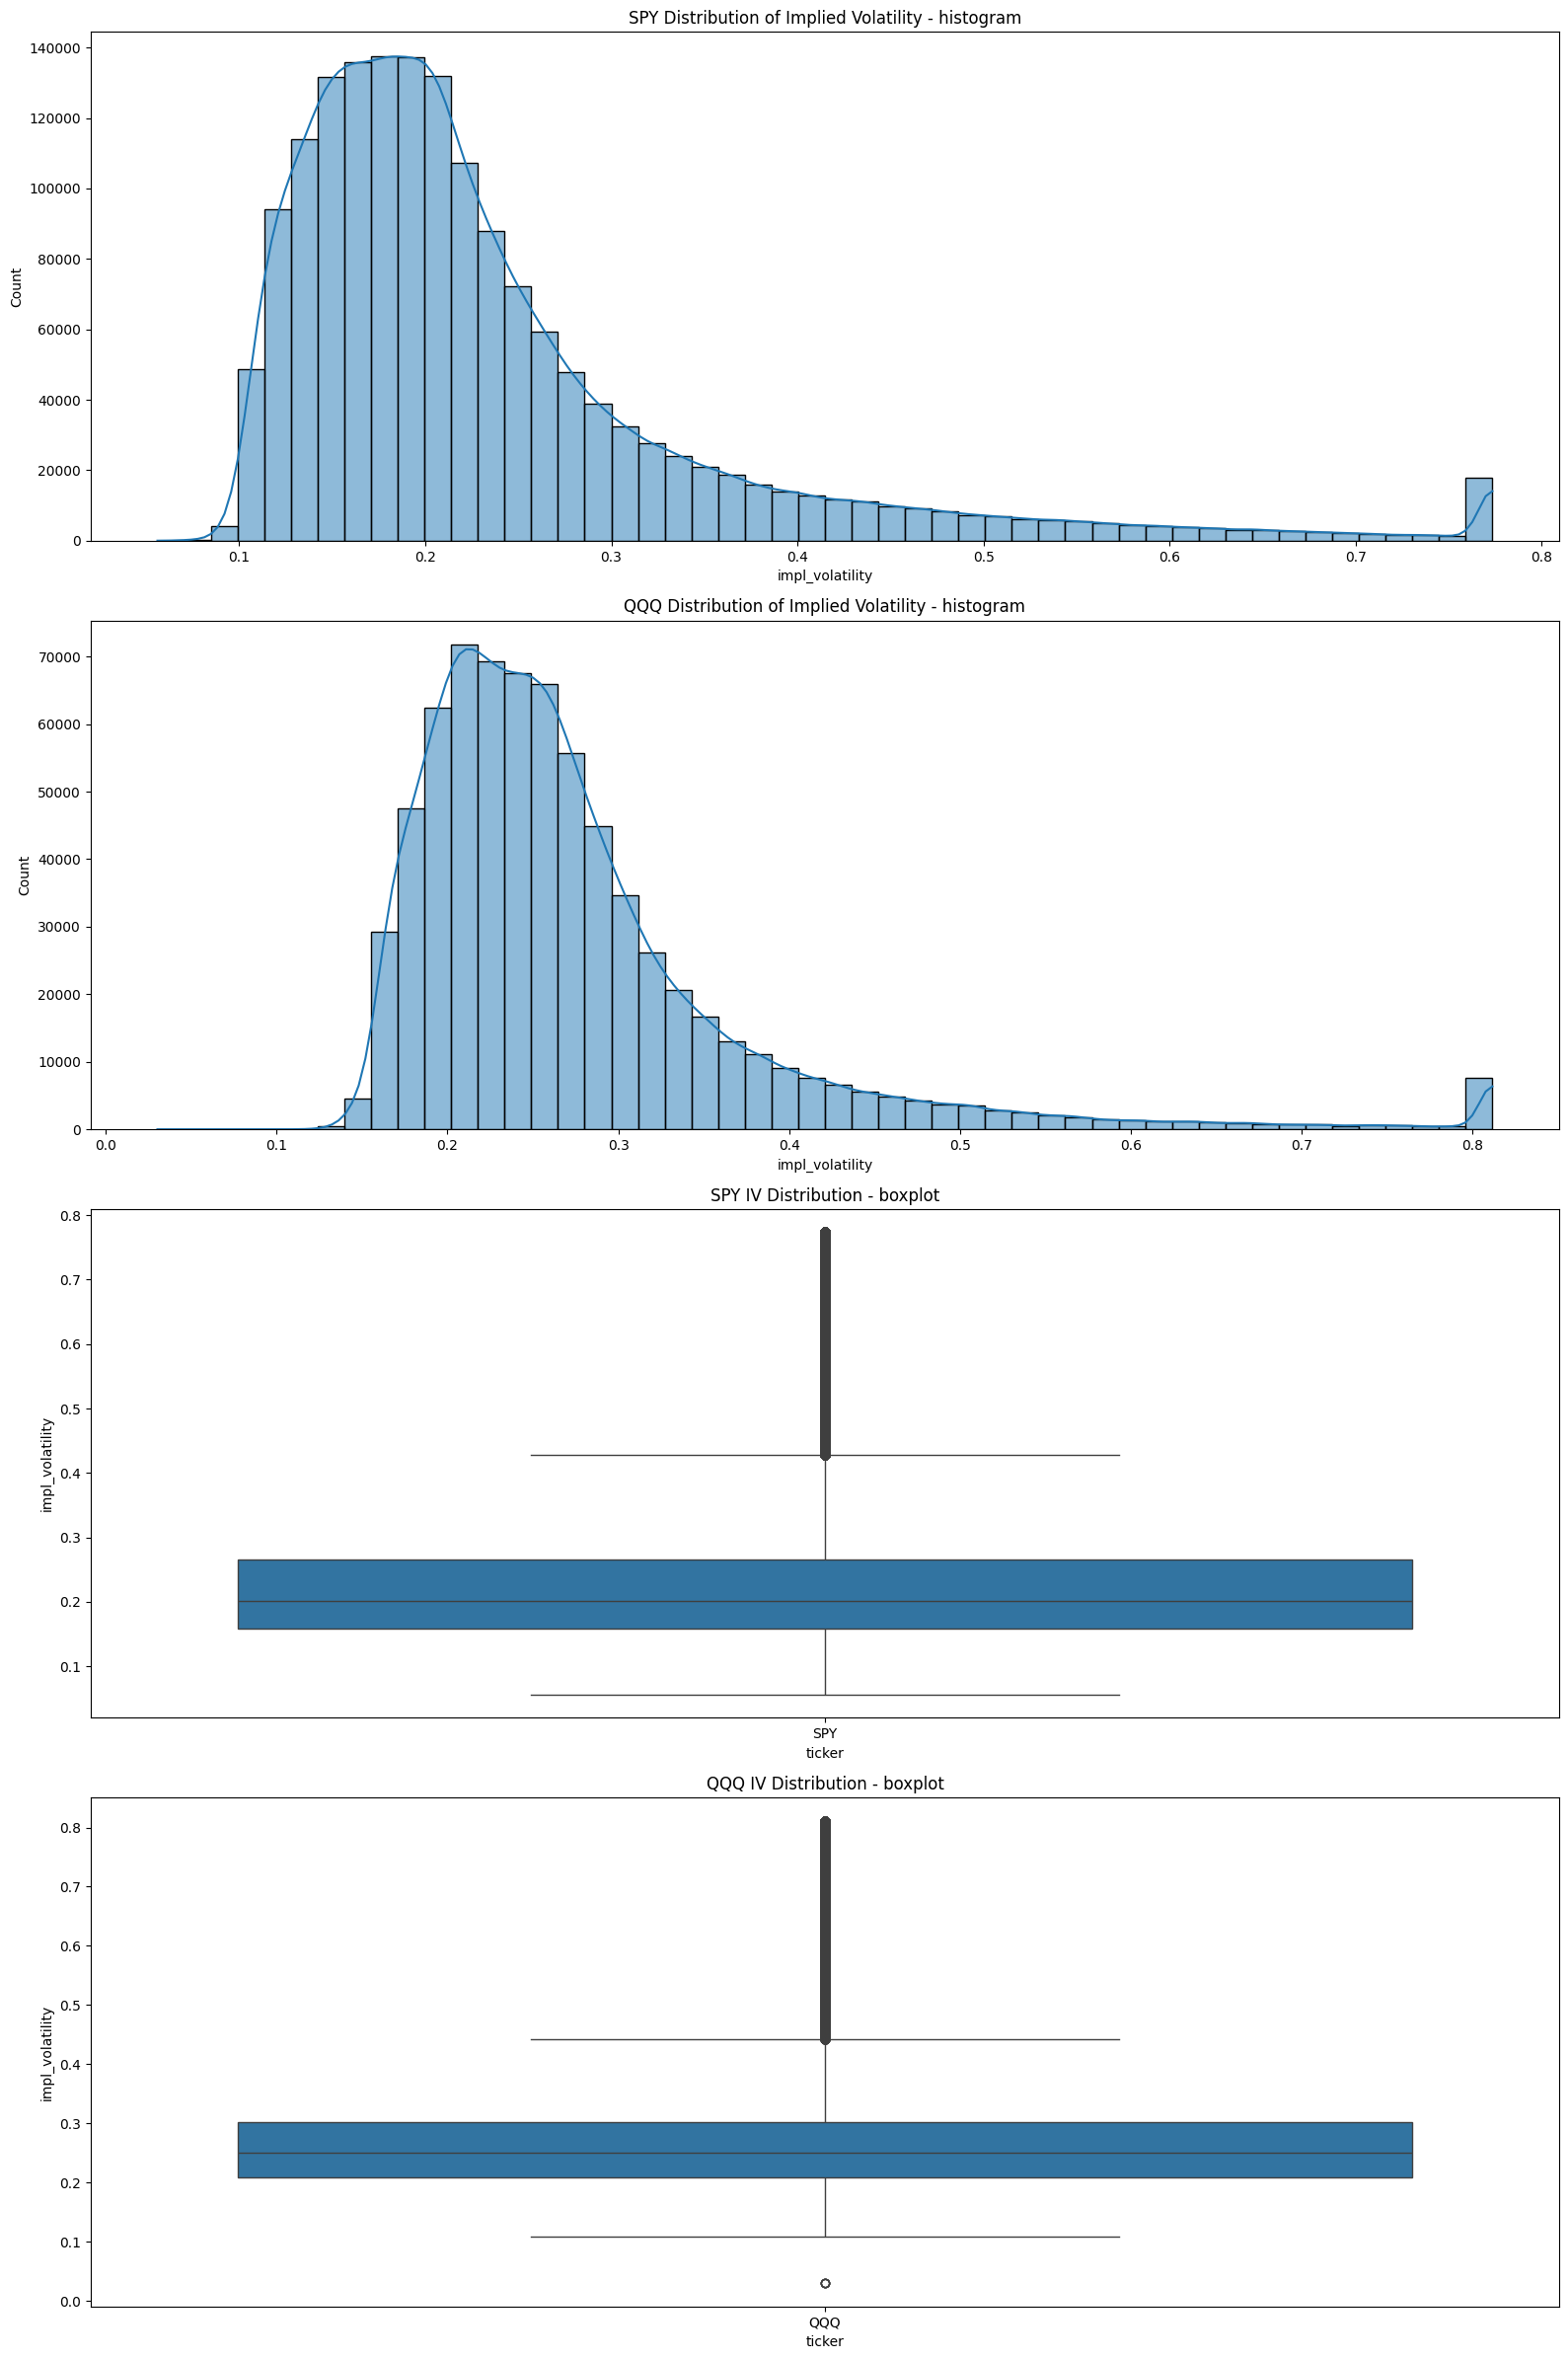

In [42]:
fig, axes = plt.subplots(4,1, figsize=(16,24))

# SPY Distribution of IV
sns.histplot(data=spy_df, x='impl_volatility', bins=50, kde=True, ax = axes[0])
axes[0].set_title("SPY Distribution of Implied Volatility - histogram")

# QQQ Distribution of IV
sns.histplot(data=qqq_df, x='impl_volatility', bins=50, kde=True, ax = axes[1])
axes[1].set_title("QQQ Distribution of Implied Volatility - histogram")

# SPY IV Distribution Boxplot
sns.boxplot(x='ticker', y='impl_volatility', data=spy_df, ax = axes[2])
axes[2].set_title("SPY IV Distribution - boxplot")

# QQQ IV Distribution Boxplot
sns.boxplot(x='ticker', y='impl_volatility', data=qqq_df, ax = axes[3])
axes[3].set_title("QQQ IV Distribution - boxplot")

plt.tight_layout()
plt.show()

Implied volatility is concentrated between roughly 15% and 30%, with very few outliers above 30%. This suggests the dataset is clean after filtering. SPY and QQQ show broadly similar IV distributions, with QQQ’s median only slightly higher, reflecting modest sector risk differences. Outliers above 0.3 may represent short‑term stress events or occasional bad quotes, but they are rare and do not dominate the distribution.

__Aggregate daily features (ATM IV, skew, curvature)__

In [43]:
def extract_iv_features(df):
    """Extract volatility surface and market dynamics features from DataFrame (df)."""
    features = []

    # Group by date and ticker
    for (date, ticker), group in df.groupby(['date', 'ticker']):
        group = group.copy()

        # --- ATM IV ---
        atm_row = group.iloc[(group['delta'].abs() - 0.5).abs().argsort()[:1]]
        atm_iv = atm_row['impl_volatility'].values[0]

        # --- 25-delta put and call ---
        put25 = group[group['cp_flag'] == 'P']
        call25 = group[group['cp_flag'] == 'C']

        if not put25.empty and not call25.empty:
            put25_idx = (put25['delta'] + 0.25).abs().idxmin()
            call25_idx = (call25['delta'] - 0.25).abs().idxmin()

            iv_put25 = group.loc[put25_idx, 'impl_volatility']
            iv_call25 = group.loc[call25_idx, 'impl_volatility']

            skew = iv_put25 - iv_call25
            curvature = (iv_put25 + iv_call25) / 2 - atm_iv
        else:
            skew = curvature = np.nan

        # --- Volatility-of-volatility ---
        group_sorted = group.sort_values('exdate')
        iv_std = group_sorted['impl_volatility'].std()

        # --- Greeks (averaged) ---
        avg_delta = group['delta'].mean()
        avg_vega = group['vega'].mean()
        avg_theta = group['theta'].mean()

        # --- Price momentum ---
        price_momentum = {
            f"price_diff_{d}d": group[f"price_diff_{d}d"].mean()
            for d in [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233]
            if f"price_diff_{d}d" in group.columns
        }

        features.append({
            'date': date,
            'ticker': ticker,
            'ATM_IV': atm_iv,
            'Skew': skew,
            'Curvature': curvature,
            'IV_std': iv_std,
            'Avg_Delta': avg_delta,
            'Avg_Vega': avg_vega,
            'Avg_Theta': avg_theta,
            **price_momentum
        })

    return pd.DataFrame(features)

In [44]:
spy_features = extract_iv_features(spy_df)
spy_features.sample(7)

,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_3d,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d
39,2023-03-23,SPY,0.198584,0.074314,0.014798,0.134215,0.063062,60.847764,-31.926756,0.080026,...,0.240994,0.402878,0.211255,-1.587868,-2.352717,-0.702225,2.247290,0.117145,-6.310179,-9.439630
97,2023-06-15,SPY,0.141858,0.065374,0.014951,0.162220,0.102247,58.934427,-19.494790,0.583061,...,1.754547,2.931396,4.425536,6.021536,7.859018,11.334159,15.769763,20.679507,27.333836,31.368422
131,2023-08-04,SPY,0.159422,0.072452,-0.003023,0.123344,0.089057,62.136542,-19.549252,-0.246081,...,-0.741225,-1.239351,-1.961436,-3.102228,-5.617249,-7.998922,-7.898558,-4.751947,1.150313,11.465423
104,2023-06-27,SPY,0.144720,0.034009,-0.010476,0.133999,0.120494,60.325532,-17.720792,0.460270,...,1.386966,2.319817,3.246752,3.226012,1.637956,0.152632,0.033539,2.617006,12.210449,21.131740
113,2023-07-11,SPY,0.119798,0.070492,0.026360,0.126884,0.122619,59.619488,-20.739325,0.304288,...,0.915393,1.529026,2.274328,2.944417,2.981025,1.969120,2.443765,6.705671,10.691355,17.953756
20,2023-02-24,SPY,0.192089,0.062311,0.002341,0.085022,0.003628,57.262539,-21.830383,-0.391124,...,-1.190954,-2.008367,-2.930892,-3.449141,-3.129809,-5.977747,-12.972267,-15.462805,-12.471137,-2.152244
136,2023-08-11,SPY,0.150804,0.031438,-0.012644,0.107631,0.048506,63.255136,-18.450726,-0.041218,...,-0.123961,-0.207012,-0.339932,-0.593152,-1.576518,-3.102329,-4.972791,-6.514065,-3.968798,4.250095


In [45]:
qqq_features = extract_iv_features(qqq_df)
qqq_features.sample(7)

,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_3d,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d
80,2023-06-01,QQQ,0.207613,0.044153,-0.013760,0.120469,0.151463,46.443018,-20.630756,0.545808,...,1.637424,2.745183,3.234730,3.656987,5.911583,13.553429,19.013125,24.592987,32.684768,40.785429
37,2023-03-30,QQQ,0.225586,0.065723,0.006622,0.119333,0.090853,46.135216,-23.623397,0.430922,...,1.292767,2.187074,3.730289,5.959445,7.247232,6.516666,10.090148,16.441848,19.266306,19.276435
87,2023-06-12,QQQ,0.200265,0.076767,0.006320,0.121531,0.166979,45.927724,-22.212800,0.852035,...,2.556105,4.293647,5.796991,7.428541,8.581286,8.541405,11.672553,21.663989,33.896530,46.359760
9,2023-02-17,QQQ,0.232914,0.071386,0.004417,0.041456,0.164915,46.436514,-27.192597,-0.237078,...,-0.711235,-1.231913,-2.217276,-4.586832,-6.758867,-2.908692,-1.995848,-3.448528,10.483538,27.387651
4,2023-02-10,QQQ,0.244498,0.046619,0.015499,0.056677,0.229426,47.404617,-35.502669,-0.193029,...,-0.579087,-1.030125,-1.656819,-3.044221,-6.002780,-6.723155,-8.571881,7.040311,18.448522,33.905361
12,2023-02-23,QQQ,0.241870,0.069724,-0.000151,0.121785,0.143985,42.296096,-40.943685,0.313286,...,0.939859,1.594896,2.157678,2.184957,-0.646499,-7.079690,-8.470536,-8.143071,1.459708,20.784066
54,2023-04-25,QQQ,0.231299,0.070529,-0.003747,0.078658,0.089201,46.783141,-25.597503,-0.833049,...,-2.499147,-4.195035,-5.453205,-6.531966,-7.202771,-8.164384,-7.608884,-4.698978,0.415892,11.167313


Pull in the TBills Secondary Market 3-month (dtb3) and Treasury Constant Maturity 2-year (dgs2) from WRDS FRB and join by date

In [46]:
# db = wrds.Connection(wrds_username='ayansola')
# setup pg_pass needed for access to the wrds dataset (first time only)
# db.create_pgpass_file()

In [47]:
# params = {
#     "from_date": "2022-01-01",
#     "to_date": "2023-12-31"
# }

# t_bill = db.raw_sql(
#     """
#     SELECT date, dtb3 as tbills_3m, dgs2 as treasury_2y
#     FROM frb.rates_daily
#     WHERE date BETWEEN %(from_date)s AND %(to_date)s
#     """,
#     params=params,
# )

In [48]:
# t_bill.dtypes

In [49]:
# t_bill['date'] = pd.to_datetime(t_bill['date'])

In [50]:
# t_bill.info()

In [51]:
# t_bill.head()

In [52]:
# features_df = features_df.merge(t_bill[['date','tbills_3m', 'treasury_2y']], on='date', how='left')

In [53]:
# features_df.head()

__Plot time series of ATM_IV, skew, curvature, IV_std, Avg_Vega & Price_diff_21d for SPY & QQQ__

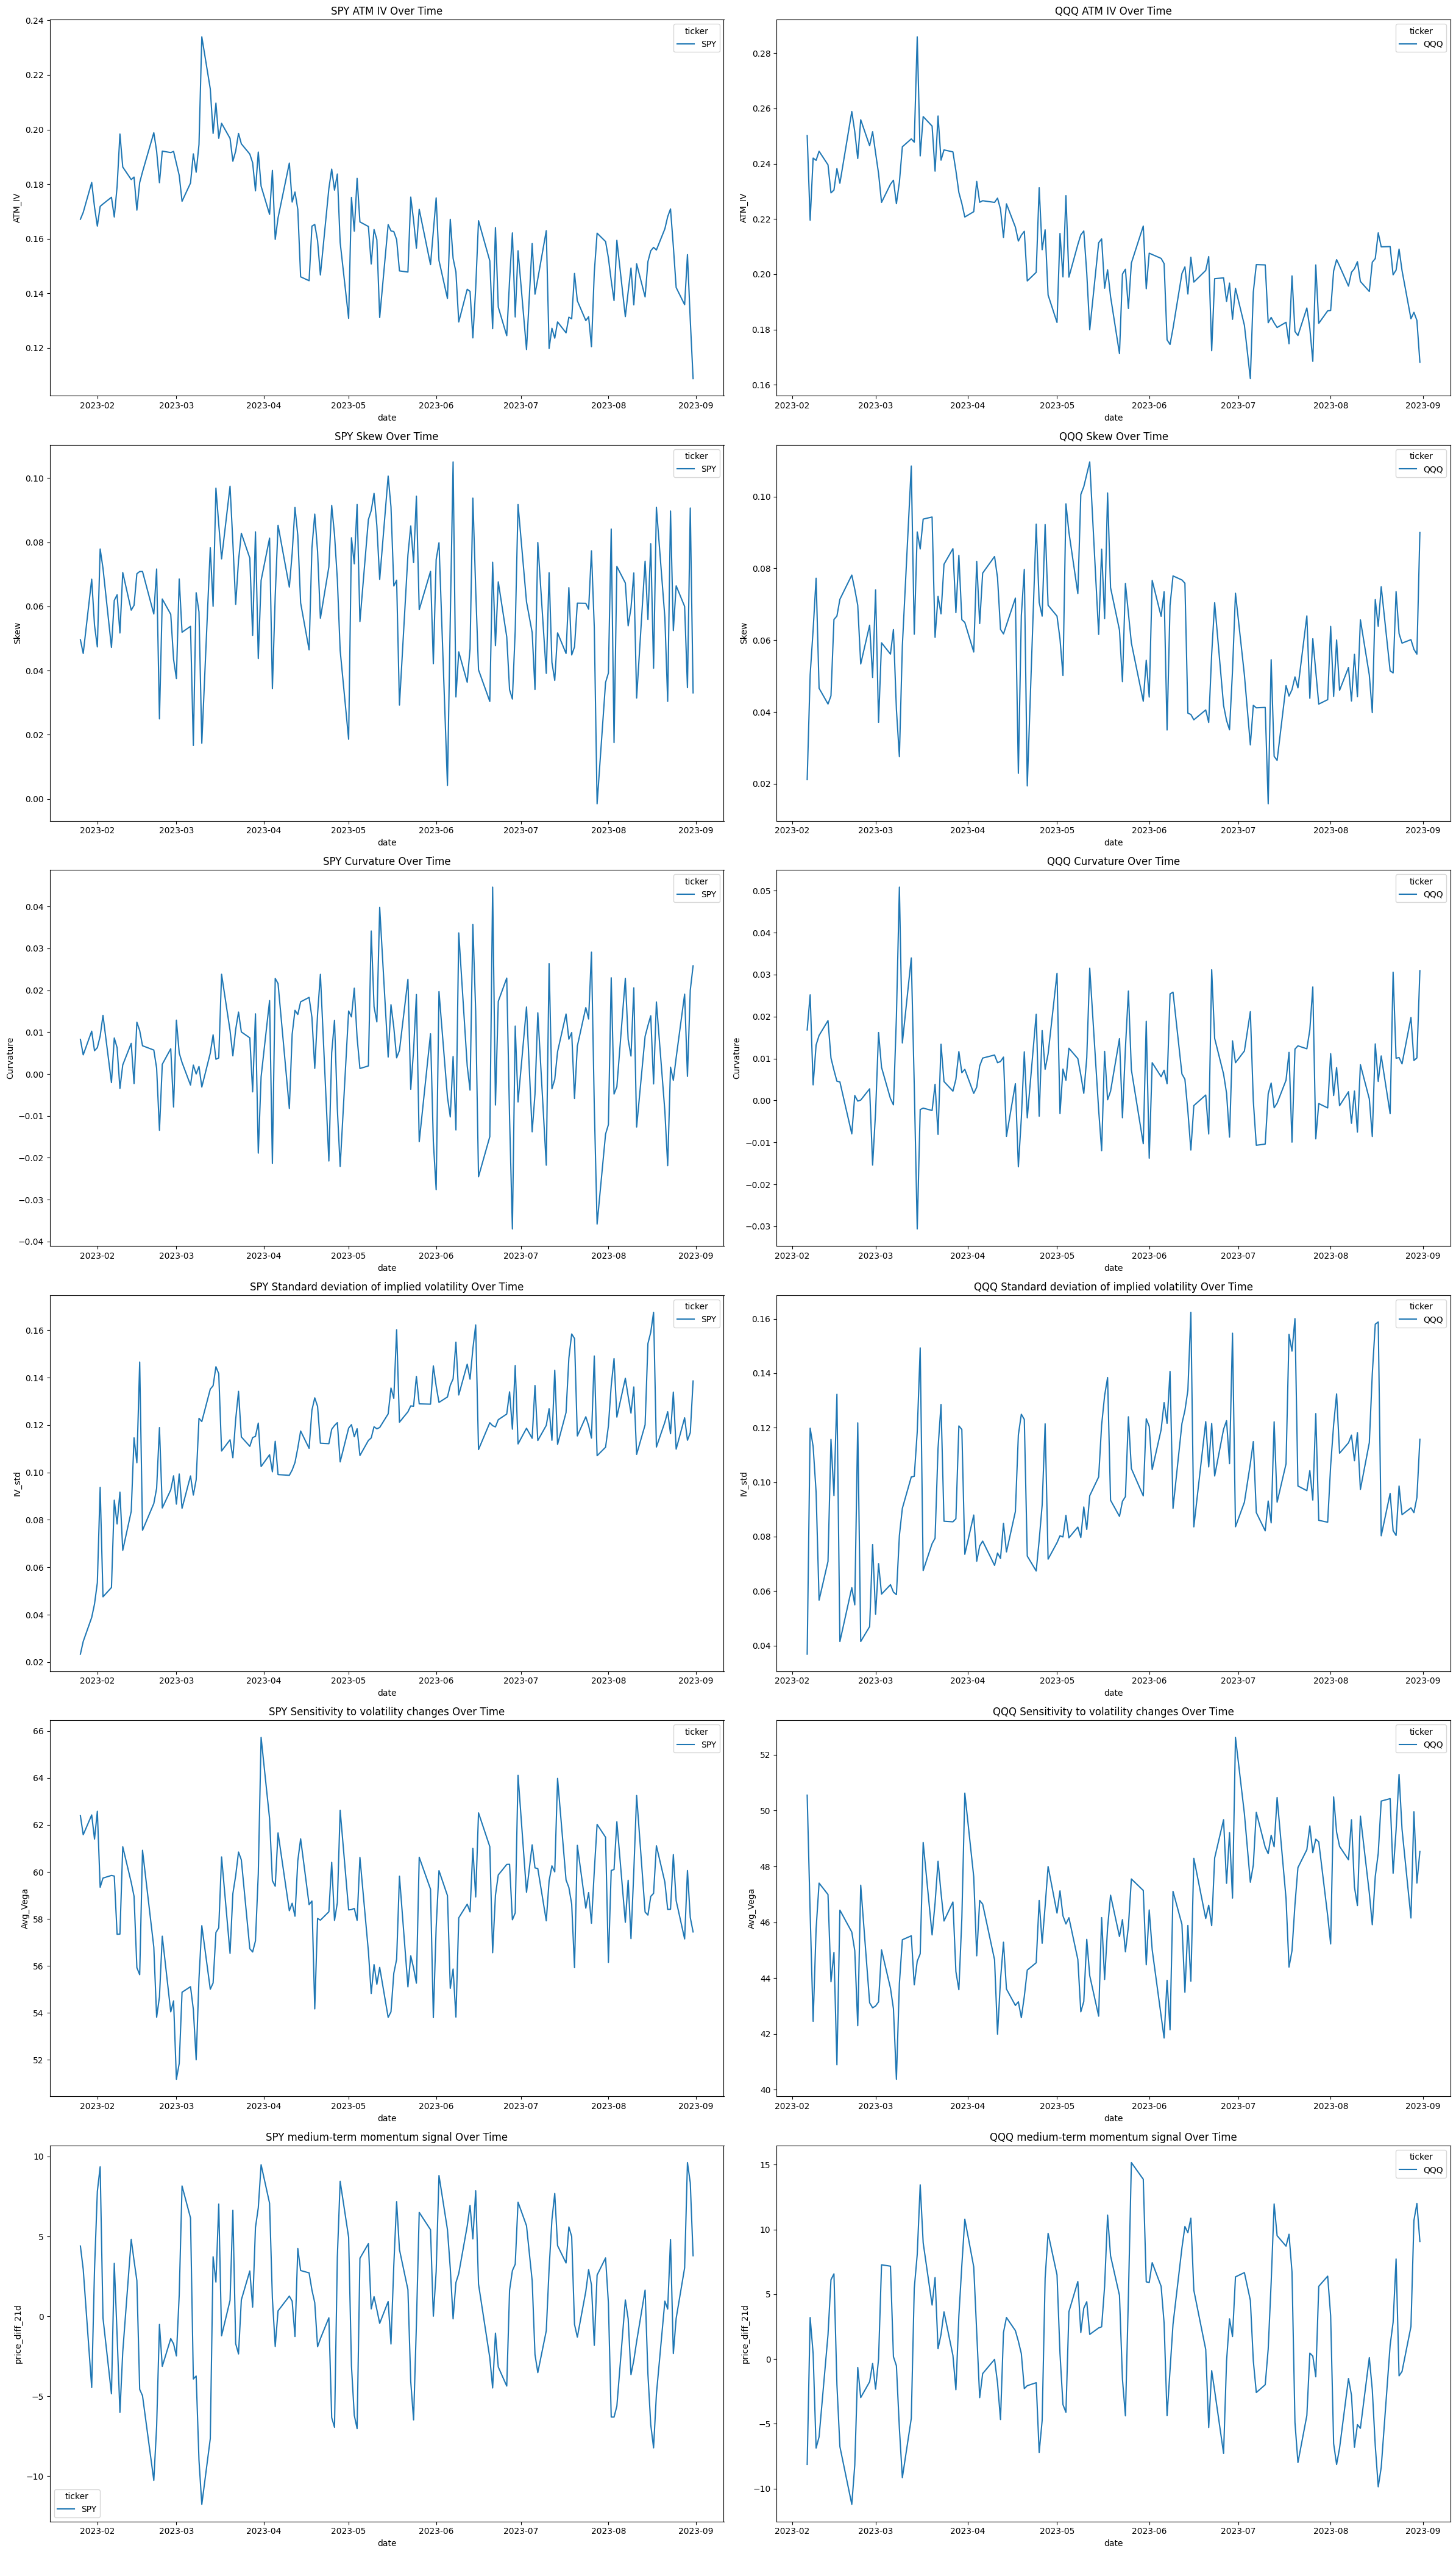

In [54]:
fig, axes = plt.subplots(6,2, figsize=(24,42))

sns.lineplot(data=spy_features, x='date', y='ATM_IV', hue='ticker', ax = axes[0, 0])
axes[0, 0].set_title("SPY ATM IV Over Time")

sns.lineplot(data=qqq_features, x='date', y='ATM_IV', hue='ticker', ax = axes[0, 1])
axes[0, 1].set_title("QQQ ATM IV Over Time")

sns.lineplot(data=spy_features, x='date', y='Skew', hue='ticker', ax = axes[1, 0])
axes[1, 0].set_title("SPY Skew Over Time")

sns.lineplot(data=qqq_features, x='date', y='Skew', hue='ticker', ax = axes[1, 1])
axes[1, 1].set_title("QQQ Skew Over Time")

sns.lineplot(data=spy_features, x='date', y='Curvature', hue='ticker', ax = axes[2, 0])
axes[2, 0].set_title("SPY Curvature Over Time")

sns.lineplot(data=qqq_features, x='date', y='Curvature', hue='ticker', ax = axes[2, 1])
axes[2, 1].set_title("QQQ Curvature Over Time")

sns.lineplot(data=spy_features, x='date', y='IV_std', hue='ticker', ax = axes[3, 0])
axes[3, 0].set_title("SPY Standard deviation of implied volatility Over Time")

sns.lineplot(data=qqq_features, x='date', y='IV_std', hue='ticker', ax = axes[3, 1])
axes[3, 1].set_title("QQQ Standard deviation of implied volatility Over Time")

sns.lineplot(data=spy_features, x='date', y='Avg_Vega', hue='ticker', ax = axes[4, 0])
axes[4, 0].set_title("SPY Sensitivity to volatility changes Over Time")

sns.lineplot(data=qqq_features, x='date', y='Avg_Vega', hue='ticker', ax = axes[4, 1])
axes[4, 1].set_title("QQQ Sensitivity to volatility changes Over Time")

sns.lineplot(data=spy_features, x='date', y='price_diff_21d', hue='ticker', ax = axes[5, 0])
axes[5, 0].set_title("SPY medium-term momentum signal Over Time")

sns.lineplot(data=qqq_features, x='date', y='price_diff_21d', hue='ticker', ax = axes[5, 1])
axes[5, 1].set_title("QQQ medium-term momentum signal Over Time")

# sns.lineplot(data=features_df, x='date', y='tbills_3m', ax = axes[3])
# axes[3].set_title("3 month TBills Secondary Market Over Time")

# sns.lineplot(data=features_df, x='date', y='treasury_2y', ax = axes[4])
# axes[4].set_title("Treasury Constant Maturity 2-year Over Time")


# sns.lineplot(data=features_df, x='date', y='dtb1yr', ax = axes[3])
# axes[6].set_title("1 year TBills Secondary Market Over Time")

plt.tight_layout()
plt.show()

- Both symbols experience occasional, brief volatility spikes, with QQQ’s being more pronounced.

- QQQ’s skew is more volatile and often higher, pointing to increased demand for put options

- Curvature is persistently positive for both

- Implied volatility doesn’t track with short‑term rates like the 3‑month bill, but it does respond more visibly to shifts in the 2‑year yield as seen above

In [55]:
# drop dtb3 since IV doesn't track with it
# features_df = features_df.drop(columns=['tbills_3m'])

__Correlation checks__

In [56]:
# metrics = ['ATM_IV', 'Skew', 'Curvature']

# for metric in metrics:
#     pivot = features_df.pivot(index='date', columns='ticker', values=metric)
#     corr = pivot.corr()
#     sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
#     plt.title(f"Correlation of {metric} between SPY and QQQ")
#     plt.show()

In [57]:
spy_features.isna().sum()

date               0
ticker             0
ATM_IV             0
Skew               0
Curvature          0
IV_std             0
Avg_Delta          0
Avg_Vega           0
Avg_Theta          0
price_diff_1d      0
price_diff_2d      0
price_diff_3d      0
price_diff_5d      0
price_diff_8d      0
price_diff_13d     0
price_diff_21d     0
price_diff_34d     0
price_diff_55d     0
price_diff_89d     0
price_diff_144d    0
price_diff_233d    0
dtype: int64

In [58]:
qqq_features.isna().sum()

date               0
ticker             0
ATM_IV             0
Skew               0
Curvature          0
IV_std             0
Avg_Delta          0
Avg_Vega           0
Avg_Theta          0
price_diff_1d      0
price_diff_2d      0
price_diff_3d      0
price_diff_5d      0
price_diff_8d      0
price_diff_13d     0
price_diff_21d     0
price_diff_34d     0
price_diff_55d     0
price_diff_89d     0
price_diff_144d    0
price_diff_233d    0
dtype: int64

Volatility levels between SPY and QQQ are highly synchronized, skew is moderately aligned but allows for divergence, and curvature behaves almost independently.

In [59]:
series = spy_features['ATM_IV']
result = adfuller(series.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.8330534562229364
p-value: 0.3641793887555453


In [60]:
series = qqq_features['ATM_IV']
result = adfuller(series.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.3739000784378392
p-value: 0.5947228338014059


### EDA Summary
- **Data quality:** No major missing values.
- **Distributions:** SPY && QQQ IV show broadly similar distributions with SPY IV centered lower than QQQ
- **Time series:** Both symbols show volatility spikes around market stress dates.
- **Correlations:** ATM IV highly correlated (SPY vs QQQ ~0.8).

__Save Aggregate daily features to Parquet: partition by symbol/year for downstream use.__

In [61]:
spy_features['year'] = pd.to_datetime(spy_features['date']).dt.year

# Write to Parquet with partitioning
spy_features.to_parquet(
    "spy_features_parquet/",
    engine="pyarrow",        # or "fastparquet"
    partition_cols=["year"],
    index=False
)

In [62]:
qqq_features['year'] = pd.to_datetime(qqq_features['date']).dt.year

# Write to Parquet with partitioning
qqq_features.to_parquet(
    "qqq_features_parquet/",
    engine="pyarrow",        # or "fastparquet"
    partition_cols=["year"],
    index=False
)